In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import time

import py_analyze_tools.tools as pat
import analyze_tools as at

# Cross validate with two realisations
Two realisations with different initial conditions, but with the same generating reactions. Train with one, test with the other.

In [2]:
class CVTwoRealisations(object):
    def __init__(self, traj_train, traj_test):
        assert traj_train.time_step == traj_test.time_step
        # hyperparameter scales with number of basis functions
        assert traj_train.n_basis_functions == traj_test.n_basis_functions
        self._traj_train = traj_train
        self._traj_test = traj_test
        self._scale =  1. / (traj_train.n_species * traj_train.n_time_steps)

    def calculate_cost(self, alphas, train_indices, test_indices):
        from pathos.multiprocessing import Pool

        large_theta_train = np.array([f(self._traj_train.counts[train_indices]) for f in self._traj_train.thetas])
        large_theta_train = np.transpose(large_theta_train, axes=(1, 0, 2))
        dtraining_data_dt = self._traj_train.dcounts_dt[train_indices]

        large_theta_test = np.array([f(self._traj_test.counts[test_indices]) for f in self._traj_test.thetas])
        large_theta_test = np.transpose(large_theta_test, axes=(1, 0, 2))
        dtest_data_dt = self._traj_test.dcounts_dt[test_indices]

        with Pool(processes=8) as p:
            coefficients = p.map(
                lambda x: pat.frobenius_l1_regression(
                    x, self._traj_train.n_time_steps, self._traj_train.n_basis_functions, 
                    self._traj_train.n_species, large_theta_train, dtraining_data_dt,
                    scale=self._scale
                ), alphas
            )

        cost_learn = []
        cost_test = []
        for coeff in coefficients:
            cost_learn.append(
                at.lasso_minimizer_objective_fun(coeff, 0.0, self._scale * large_theta_train, self._scale * dtraining_data_dt)
            )
            cost_test.append(
                at.lasso_minimizer_objective_fun(coeff, 0.0, self._scale * large_theta_test, self._scale * dtest_data_dt)
            )
        return alphas, np.array(cost_learn), np.array(cost_test)

## Show estimation of individual trajs with some hyperparameter $\alpha$

In [50]:
def show_lasso_estimate(traj, alpha):
    traj.add_fusion(0, 1, 2) # A + B -> C, true
    traj.add_fusion(2, 3, 1) # C + D -> B, true
    traj.add_fission(2, 0, 1) # C -> A + B, nope
    traj.add_conversion(0, 1) # A -> B, nope
    traj.add_conversion(0, 3) # A -> D, true
    traj.add_conversion(3, 0) # D -> A, true
    xi = traj.estimate(alpha)

    def fun(data, _):
        theta = np.array([f(data) for f in traj.thetas])
        return np.matmul(xi, theta)

    num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
    for i in range(traj.n_species):
        plt.plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i], "--")
        plt.plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    plt.ylabel("Number of particles")
    plt.xlabel("Time")
    return xi

max counts = 6000.0, min nonzero counts = 2.0
[  1.96209375e-06   1.98554541e-06   7.64276247e-10   0.00000000e+00
   1.01564625e-02   9.76013851e-03]


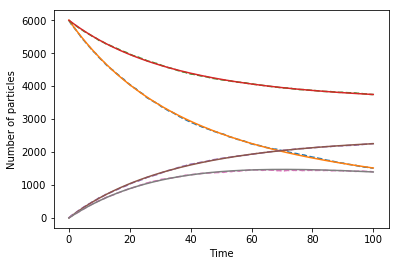

In [51]:
traj_1 = pat.Trajectory("../generate/two_realisations_1.h5")
traj_1.counts = traj_1.counts[:10000]
xi_1 = show_lasso_estimate(traj_1, 0.003)
print(xi_1)
plt.show()

max counts = 8000.0, min nonzero counts = 1.0
[  1.91647829e-06   2.24839192e-06   5.74168701e-10   0.00000000e+00
   9.46748054e-03   7.13397365e-03]


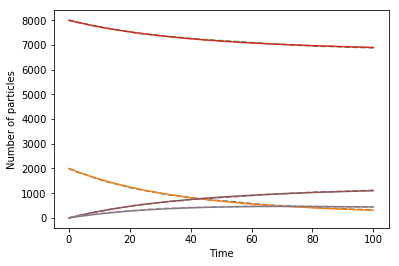

In [52]:
traj_2 = pat.Trajectory("../generate/two_realisations_2.h5")
traj_2.counts = traj_2.counts[:10000]
xi_2 = show_lasso_estimate(traj_2, 0.003)
print(xi_2)
plt.show()

## Cross validate traj_1 and traj_2 to find optimal hyperparameter $\hat{\alpha}$

In [10]:
cv = CVTwoRealisations(traj_1, traj_2)

In [15]:
t1 = time.time()
alphas_very_coarse, cost_learn_very_coarse, cost_test_very_coarse = cv.calculate_cost(
    np.arange(0,2.,.05), range(0, 5000), range(5000, 10000))
print("Duration: ", time.time() - t1)

Duration:  236.08520793914795


In [11]:
t1 = time.time()
alphas_coarse, cost_learn_coarse, cost_test_coarse = cv.calculate_cost(
    np.arange(0,0.2,.005), range(0, 5000), range(5000, 10000))
print("Duration: ", time.time() - t1)

Duration:  207.7858920097351


In [13]:
t1 = time.time()
alphas_fine, cost_learn_fine, cost_test_fine = cv.calculate_cost(
    np.arange(0,0.02,.0005), range(0, 5000), range(5000, 10000))
print("Duration: ", time.time() - t1)

Duration:  226.58009600639343


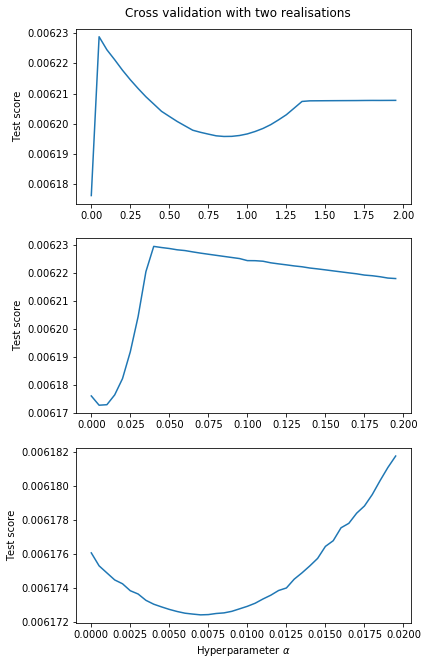

In [54]:
fig, axarr = plt.subplots(3, figsize=(6,10))
axarr[0].plot(alphas_very_coarse, cost_test_very_coarse)
axarr[1].plot(alphas_coarse, cost_test_coarse)
axarr[2].plot(alphas_fine, cost_test_fine)
axarr[2].set_xlabel(r"Hyperparameter $\alpha$")
for i in range(3): axarr[i].set_ylabel(r"Test score")
fig.suptitle("Cross validation with two realisations")
plt.subplots_adjust(top=0.95)
plt.savefig("cv_two_realisations.png")
plt.show()

In [49]:
optimal_alpha = alphas_fine[np.argmin(cost_test_fine)]
print("Optimal alpha: ", optimal_alpha)

Optimal alpha:  0.007


max counts = 6000.0, min nonzero counts = 2.0
propensities for optimal alpha [  9.86332379e-07   1.01068368e-06   0.00000000e+00   0.00000000e+00
   5.01410136e-03   4.69341101e-03   9.79697237e-07   1.01068368e-06
   0.00000000e+00   0.00000000e+00   5.01410212e-03   4.69341118e-03]


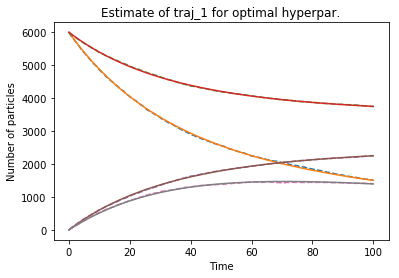

max counts = 8000.0, min nonzero counts = 1.0
propensities for optimal alpha [  9.70326648e-07   1.48184456e-06   0.00000000e+00   0.00000000e+00
   4.21502618e-03   2.10146155e-03   9.70326815e-07   1.48184457e-06
   0.00000000e+00   0.00000000e+00   4.21502634e-03   2.10148083e-03]


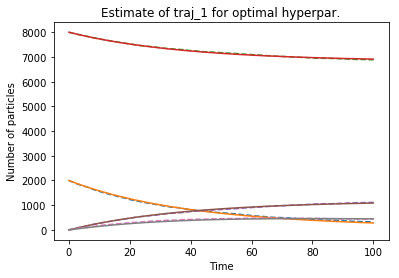

In [53]:
xi_1 = show_lasso_estimate(traj_1, optimal_alpha)
print("propensities for optimal alpha", xi_1)
plt.title("Estimate of traj_1 for optimal hyperpar.")
plt.savefig("cv_two_realisations_estimate_traj1.png")
plt.show()

xi_2 = show_lasso_estimate(traj_2, optimal_alpha)
print("propensities for optimal alpha", xi_2)
plt.title("Estimate of traj_1 for optimal hyperpar.")
plt.savefig("cv_two_realisations_estimate_traj2.png")
plt.show()